In [22]:
import matplotlib.pyplot as plt
import numpy as np
import os
import textwrap

import torch
from torchvision import transforms
from torch.utils.data import DataLoader

from datasets.cityscapes import Cityscapes
from utils import load_model, get_image_labels, important_classes

In [2]:
root = os.getcwd()

# Path to your cityscapes dataset folder
data_path = os.path.join(root, 'cityscapes')

# Path your model weights folder
model_path = os.path.join(root, 'models')

In [3]:
# Name of the model to test
model_name = 'resnet_scratch_10ep.tar'
#model_name = 'inception_frozen_0001lr.tar'

In [4]:
# Load in the model
model, optimizer, criterion, epoch, device = load_model(
                                        os.path.join(model_path, model_name))

In [5]:
input_size = (256, 512)
original_size = (1024, 2048)
num_workers = 12

In [6]:
data_transforms = transforms.Compose([transforms.Resize(input_size),
                                              transforms.ToTensor()])

resize_to_orig = transforms.Compose([transforms.ToPILImage(),
                                            transforms.Resize(original_size)])

In [7]:
# List of perturbations we'll test the model on
perturbations = ['none', 'fog', 'rain', 'snow', 'occlusion']

In [8]:
# Dataset and dataloader dictionaries indexed by the 
# type of perturbation it applies to images
datasets = {i: Cityscapes(data_path,
                               split='val',
                               mode='coarse',
                               target_type=['polygon'],
                               transform=data_transforms,
                               target_transform=get_image_labels,
                               perturbation=i)
                 for i in perturbations}

In [9]:
num_testing_files = datasets['none'].__len__()
print('Testing on {} test files\n'.format(num_testing_files))

Testing on 500 test files



In [28]:
def test_model(num_imgs, model, perturbs, datasets):
    # Create subplot layout and adjust vertical spacing
    fig, axs = plt.subplots(len(perturbs), num_imgs, figsize=(15,15))
    plt.subplots_adjust(hspace = 0.8)
    
    dataset_len = datasets['none'].__len__()
    
    for n in range(num_imgs):
        # Choose a random image
        idx = np.random.randint(0, dataset_len)
        
        # Apply and display each perturbation
        for p, perturb in enumerate(perturbs):
            image, labels = datasets[perturb][idx]
            
             # Place image/labels on gpu and add batch dimension
            image = image.to(device)
            labels = labels.to(device)
            image = image.unsqueeze(0)
            
            with torch.no_grad():
                outputs = model(image)

                # Get the prediction
                preds = (torch.sigmoid(outputs) > 0.5).int()
                
            # Resizing image to its original shape
            image = resize_to_orig(image.squeeze().cpu())
            
            # Create list of labels from one-hot tensor
            label_list = []
            pred_list = []
            labels, preds = labels.squeeze(), preds.squeeze()
            for i in range(labels.size(0)):
                if labels[i] == 1:
                    label_list.append(important_classes[i])
                if preds[i] == 1:
                    pred_list.append(important_classes[i])
            
            ax = axs[p, n]
            ax.set_title('Perturbation: {}\nLabels: {}\nPreds: {}'.format(
                                        perturb, 
                                        textwrap.fill(', '.join(label_list), 40),
                                        textwrap.fill(', '.join(pred_list), 40)))
            ax.axis('off')
            ax.imshow(image)

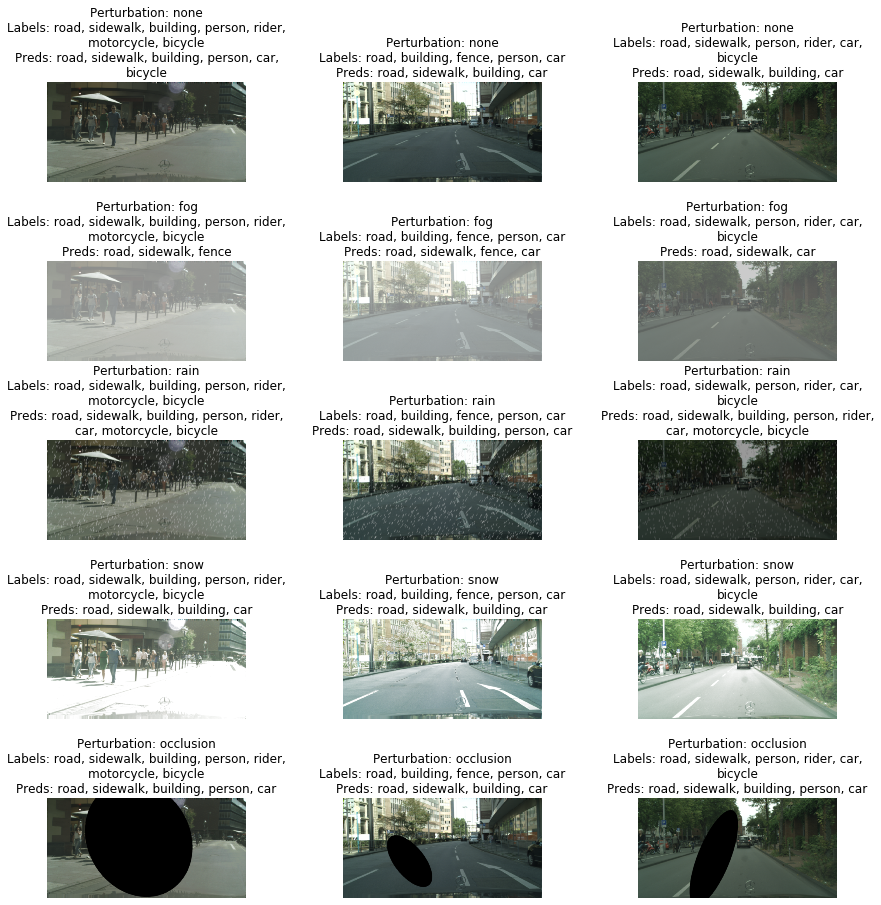

In [29]:
test_model(3, model, perturbations, datasets)